{download}`Download this notebook <4_network_reconstruction.ipynb>`

## Learning the network structure from the dynamics 

> **`gradnet` concepts demonstrated below**
> - **ODE integration** via `gradnet.integrate_ode`
> - Custom **loss function** for reconstructing the underlying network based on the dynamical system
> - Optimizer selection
> - Learning rate scheduler
> - Logging with TensorBoard
> - Integrating an ODE with events


### Problem setup
Simulate Kuramoto model on a network, measure the phases and use these phases to reconstruct the network structure.

### Generate ground-truth ER graph and simulate Kuramoto data

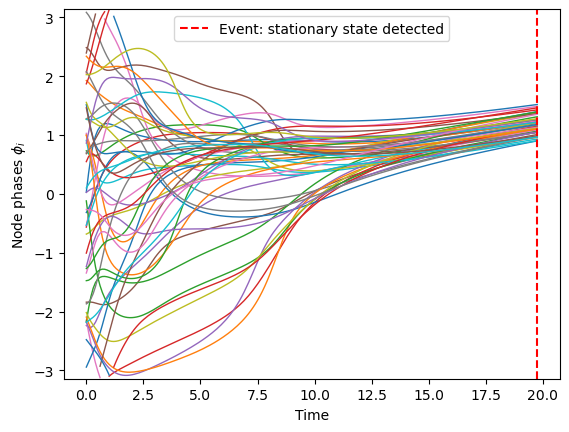

In [ ]:
import math
import torch
from gradnet import GradNet, ode
from gradnet.trainer import fit
from gradnet.utils import plot_adjacency_heatmap, random_seed
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from matplotlib.lines import Line2D

random_seed(42)

N = 50
degree = 3

net_true = nx.random_regular_graph(degree, N)
A_true = torch.tensor(nx.to_numpy_array(net_true))

omega = torch.rand(N)-0.5
theta0 = 2 * math.pi * torch.rand(N)

T_final = 100  # arbitrary large final time. Integration will stop much earlier once system synchronizes 
tt = torch.linspace(0.0, T_final, T_final*10)


def kuramoto_rhs(t, theta, A, omega):
    sinx = torch.sin(theta)
    cosx = torch.cos(theta)
    return omega + cosx * (A @ sinx) - sinx * (A @ cosx)

"Event function to stop integration when the system has fully phase-locked."
def stationary_state_event(t, y, A, omega):
    dtheta_dt = kuramoto_rhs(t, y, A, omega)
    return torch.norm(dtheta_dt-dtheta_dt.mean()) - 0.05  # dtheta_dt.mean() removes the common drift

# simulate kuramoto model
tt, theta_obs, t_synched, theta_synched = ode.integrate_ode(A_true,
                                                            f=kuramoto_rhs,
                                                            x0=theta0,
                                                            tt=tt,
                                                            f_kwargs={"omega": omega},
                                                            track_gradients=False,
                                                            event_fn=stationary_state_event)
time_steps = len(tt)

# Plot measured phases 
wrap_pi = lambda x: (x + np.pi) % (2*np.pi) - np.pi
for y in map(wrap_pi, theta_obs.T):
    y[np.abs(np.diff(y, prepend=y[0])) > np.pi] = np.nan  # remove artefact jumps
    plt.plot(tt, y, lw=1)
plt.ylim(-np.pi, np.pi); 
plt.xlabel('Time'); 
plt.ylabel(r'Node phases $\phi_i$')
plt.axvline(t_synched.item(), color='red', linestyle='--', label='Event: stationary state detected')
plt.legend()
plt.show()

### Fit GradNet to the observed trajectories

In [4]:
budget = float(A_true.sum().item())

gn_recon = GradNet(num_nodes=N, budget=budget, rand_init_weights=False, use_budget_up=True)

def reconstruction_loss(gn):
    '''Here we predict each time step from the previous one, assuming the current gn is 
    the substrate network. We compare each predicted step to the actual observed step.
    The loss is the mean squared error in the (sin, cos) representation of the phases.
    If the loss=0, we have predicted each step perfectly.
    '''
    loss_sum = 0
    norm_factor = (time_steps - 1) * N

    for t_idx in range(1, time_steps):
        theta_init = theta_obs[t_idx - 1]
        tt_step = tt[t_idx - 1 : t_idx + 1]

        _, theta_step_pred = ode.integrate_ode(gn, f=kuramoto_rhs,
            x0=theta_init, tt=tt_step, f_kwargs={"omega": omega}, )

        pred_sin = torch.sin(theta_step_pred[-1])
        pred_cos = torch.cos(theta_step_pred[-1])
        target_sin = torch.sin(theta_obs[t_idx])
        target_cos = torch.cos(theta_obs[t_idx])

        sq_error = (pred_sin - target_sin) ** 2 + (pred_cos - target_cos) ** 2
        loss_sum += sq_error.sum()

    mean_loss = loss_sum / norm_factor

    missclass_num = ((gn() > 0.5) != (A_true > 0)).float().sum().item() / 2
    return mean_loss, {"missclass": missclass_num}


num_updates = 100
base_lr = 0.5

def lr_scheduler(epoch: int) -> float:
    '''This is the multiplicative factor for the base learning rate. Can be changing and depends on epochs.'''
    if epoch < num_updates * 0.2:
        return 1  # first 20% of epochs at base_lr
    if epoch < num_updates * 0.8:
        return 0.2  # next 60% of epochs at 0.2*base_lr
    return 0.02  # last 20% of epochs at 0.02*base_lr


fit(
    gn=gn_recon,
    loss_fn=reconstruction_loss,
    num_updates=num_updates,
    optim_cls=torch.optim.Adam,
    optim_kwargs={"lr": base_lr},
    sched_cls=torch.optim.lr_scheduler.LambdaLR,
    sched_kwargs={"lr_lambda": lr_scheduler},
    accelerator="cpu",
    logger=True,
);

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Updates:   0%|          | 0/100 [00:00<?, ?it/s]


  | Name | Type    | Params | Mode 
-----------------------------------------
0 | gn   | GradNet | 2.5 K  | train
-----------------------------------------
2.5 K     Trainable params
0         Non-trainable params
2.5 K     Total params
0.010     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.


To track live plots of loss and other scalars (like the number of missclassified edges in this case), you first need to ensure that tensorboard is installed: type `pip install tensorboard` in terminal.
Then you should navigate your a terminal to your python project directory and type: `tensorboard --logdir .`

### Visualization of Adjacency matrices

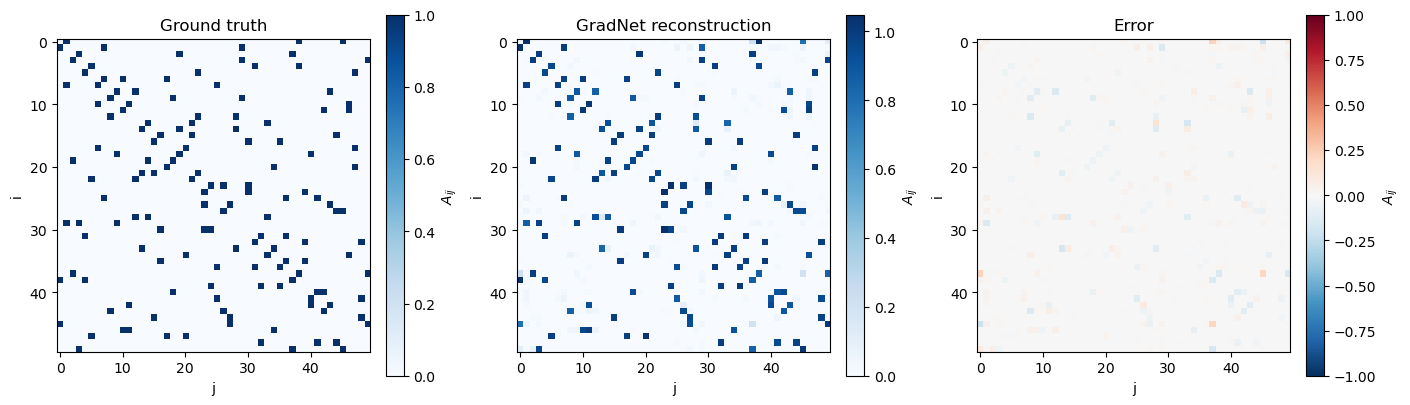

In [5]:
A_pred = gn_recon().detach()
fig, axs = plt.subplots(1, 3, figsize=(14, 4), constrained_layout=True)
plot_adjacency_heatmap(A_true, ax=axs[0], title="Ground truth", imshow_kwargs={"cmap": "Blues"})
plot_adjacency_heatmap(gn_recon, ax=axs[1], title="GradNet reconstruction", imshow_kwargs={"cmap": "Blues"})
plot_adjacency_heatmap(A_pred - A_true, ax=axs[2], title="Error", imshow_kwargs={"cmap": "RdBu_r", "vmin": -1.0, "vmax": 1.0})
for ax in axs:
    ax.set_xlabel("j")
    ax.set_ylabel("i")
plt.show()

### Evaluate reconstruction against the ground truth

In [8]:
def edge_confusion(A_true, A_pred, thr=0.5):
    '''compute true positives, false positives, false negatives'''
    i, j = torch.triu_indices(A_true.size(0), A_true.size(0), 1)
    T, P = A_true[i,j] > 0, A_pred[i,j] > thr
    tp, fp, fn = (P&T), (P&~T), (~P&T)
    get = lambda m: list(zip(i[m].tolist(), j[m].tolist()))
    return get(tp), get(fp), get(fn)

tp_edges, fp_edges, fn_edges = edge_confusion(A_true, A_pred, thr=0.5)
tp, fp, fn = len(tp_edges), len(fp_edges), len(fn_edges)

precision = tp / (tp + fp + 1e-8)
recall = tp / (tp + fn + 1e-8)
f1 = 2.0 * precision * recall / (precision + recall + 1e-8)

print(f"precision: {precision:.3f}")
print(f"recall: {recall:.3f}")
print(f"F1: {f1:.3f}")


precision: 1.000
recall: 1.000
F1: 1.000


### Network-level visualization of reconstruction quality

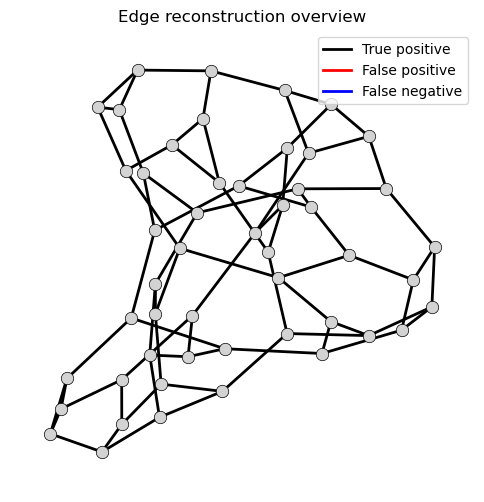

In [9]:
graph = nx.Graph()
graph.add_nodes_from(range(N))
graph.add_edges_from(tp_edges + fp_edges + fn_edges)

pos = nx.spring_layout(graph, seed=0)

fig_graph, ax_graph = plt.subplots(figsize=(6, 6))
nx.draw_networkx_nodes(graph, pos, ax=ax_graph, node_size=80,
                       node_color="lightgray", edgecolors="black", 
                       linewidths=0.5)

nx.draw_networkx_edges(graph, pos, ax=ax_graph, edgelist=tp_edges, width=2, edge_color="black")
nx.draw_networkx_edges(graph, pos, ax=ax_graph, edgelist=fp_edges, width=2, edge_color="red")
nx.draw_networkx_edges(graph, pos, ax=ax_graph, edgelist=fn_edges, width=2, edge_color="blue")

ax_graph.set_title("Edge reconstruction overview")
ax_graph.set_axis_off()
legend_handles = [
    Line2D([0], [0], color="black", lw=2, linestyle="-", label="True positive"),
    Line2D([0], [0], color="red", lw=2, linestyle="-", label="False positive"),
    Line2D([0], [0], color="blue", lw=2, linestyle="-", label="False negative"),
]
ax_graph.legend(handles=legend_handles, loc="upper right")